In [79]:
import pywt
import gc
import pandas as pd
import numpy as np
import multiprocessing
import pyarrow.parquet as pq
import dask.dataframe as dd
import matplotlib.pyplot as plt
from IPython.display import display
from joblib import Parallel, delayed

In [2]:
train_meta = pd.read_csv("../data/input/metadata_train.csv")
test_meta = pd.read_csv("../data/input/metadata_test.csv")
train_meta.shape, test_meta.shape

((8712, 4), (20337, 3))

In [3]:
N_THREADS = 8
FEATURES_DIM = 1000
CLUSTER_DIM = 100
N_SAMPLES = 3
RANDOM_SEED = 2019
max_num = 127
min_num = -128
np.random.seed(RANDOM_SEED)

In [4]:
def cancellation_with_high_amplitude(signals, max_thres=127, min_thres=-128, maxTicksRemoval=500):
    signals_cancelled = signals.copy()
    argmax_point = np.where(signals >= max_thres)[0]
    argmin_point = np.where(signals <= min_thres)[0]
    cancell_point = []

    for point in argmin_point:
        cancell_area = np.arange(point, min(point+maxTicksRemoval, len(signals)-1))
        signals_cancelled[cancell_area] = 0
        cancell_point.append(cancell_area)
    for point in argmax_point:
        cancell_area = np.arange(point, min(point+maxTicksRemoval, len(signals)-1))
        signals_cancelled[cancell_area] = 0
        cancell_point.append(cancell_area)
    
    if len(cancell_point) > 0:
        cancell_point = np.unique(np.concatenate(cancell_point))

    return signals_cancelled, cancell_point

def get_cancellation_points(praq_data, sids):
    cancell_point_3 = []
    for s in sids:
        signals = praq_data[str(s)].values
        signals_cancelled, cancell_point = cancellation_with_high_amplitude(
            signals, max_thres=max_num, min_thres=min_num)
        cancell_point_3.append(cancell_point)
    
    cancell_point_3 = np.concatenate(cancell_point_3).astype(int)
    return cancell_point_3

In [5]:
def get_features(dataset='train', split_parts=10):
    if dataset == 'train':
        cache_file = 'X.npy'
        meta_file = '../data/input/metadata_train.csv'

    elif dataset == 'test':
        cache_file = 'X_test.npy'
        meta_file = '../data/input/metadata_test.csv'

    meta_df = pd.read_csv(meta_file)

    data_measurements = meta_df.pivot(
        index='id_measurement', columns='phase', values='signal_id'
    )
    data_measurements = data_measurements.values
    data_measurements = np.array_split(data_measurements, split_parts, axis=0)
    X = Parallel(n_jobs=min(split_parts, N_THREADS), verbose=1)(delayed(prep_data)(p, dataset) for p in data_measurements)
    X = np.concatenate(X, axis=0)

    return X

In [15]:
def prep_data(signal_ids, dataset="train"):
    signal_ids_all = np.concatenate(signal_ids)
    if dataset == "train":
        praq_data = pq.read_pandas('../data/input/train.parquet', columns=[str(i) for i in signal_ids_all]).to_pandas()
    elif dataset == "test":
        praq_data = pq.read_pandas('../data/input/test.parquet', columns=[str(i) for i in signal_ids_all]).to_pandas()
    else:
        raise ValueError("Unknown dataset")

    X = []
    for sids in signal_ids:
        signals_3 = praq_data[[str(s) for s in sids]].values.T    
        cancell_point_3 = get_cancellation_points(praq_data, sids)
        X_signal = []

        for i in range(3):
            signals = signals_3[i, :]
            fft = np.fft.rfft(signals)
            fft = np.abs(fft)
            fft = np.array_split(fft, FEATURES_DIM)
            fft = [np.median(d) for d in fft]
            X_signal.append(fft)
      
        X_signal = np.concatenate(X_signal, axis=0)
        X.append(X_signal)

    X = np.asarray(X)
    return X

In [16]:
x_train = get_features("train", split_parts=8)
x_train.shape

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  2.3min remaining:  6.8min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.3min finished


(2904, 3000)

In [17]:
import sklearn.base
import bhtsne

class BHTSNE(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, dimensions=2, perplexity=30.0, theta=0.5, rand_seed=-1, max_iter=100):
        self.dimensions = dimensions
        self.perplexity = perplexity
        self.theta = theta
        self.rand_seed = rand_seed
        self.max_iter = max_iter

    def fit_transform(self, X):
        return bhtsne.tsne(
            X.astype(np.float64),
            dimensions=self.dimensions,
            perplexity=self.perplexity,
            theta=self.theta,
            rand_seed=self.rand_seed
        )

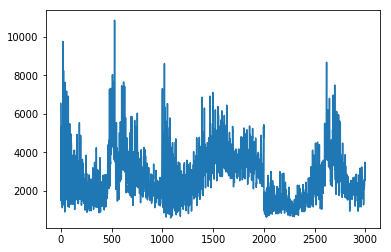

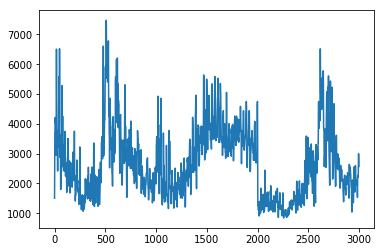

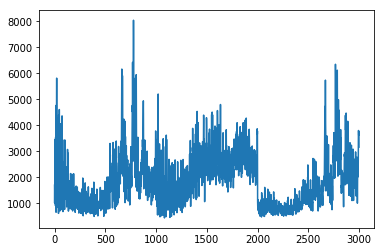

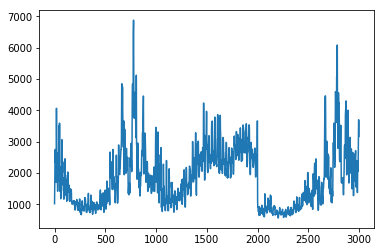

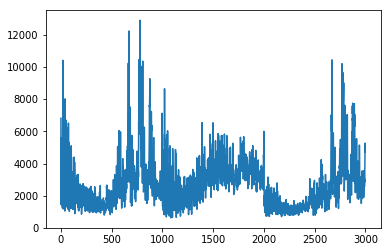

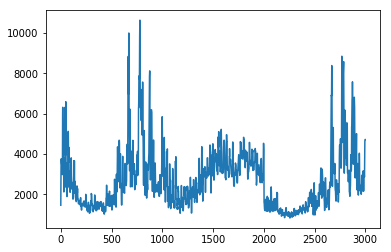

In [21]:
from scipy.signal import medfilt
for i in [262, 93, 235]:
    test_ts = x_train[i, :].copy()
    plt.plot(test_ts)
    plt.show()
    
    test_ts = medfilt(test_ts, kernel_size=5)
    plt.plot(test_ts)
    plt.show()

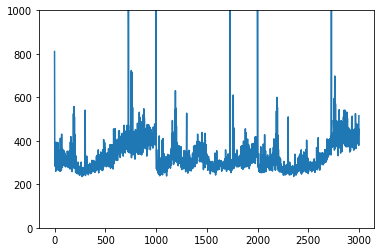

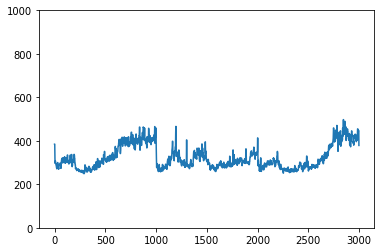

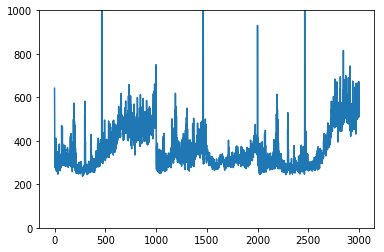

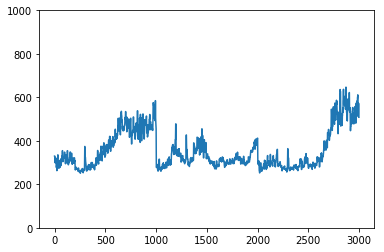

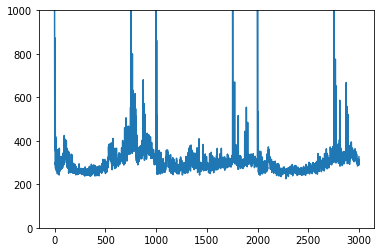

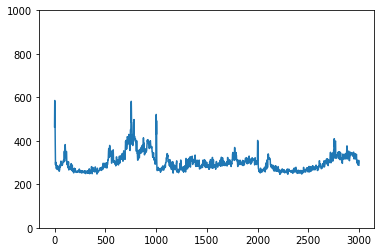

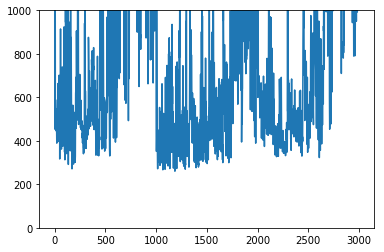

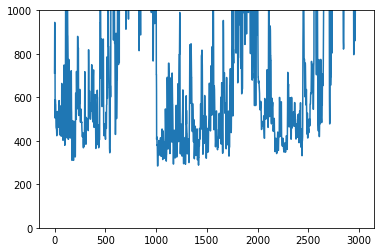

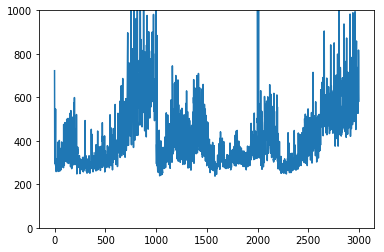

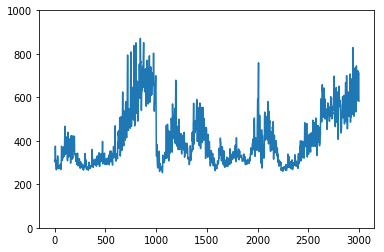

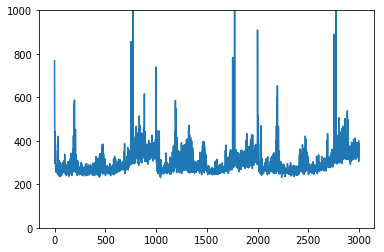

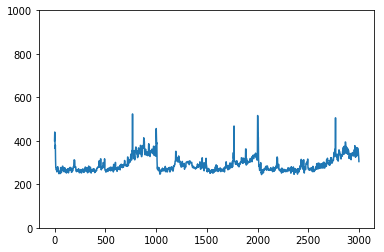

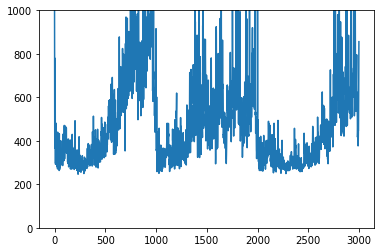

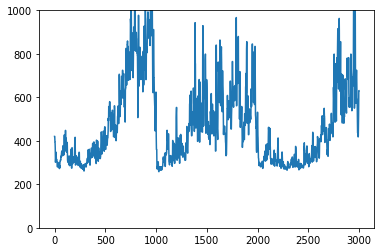

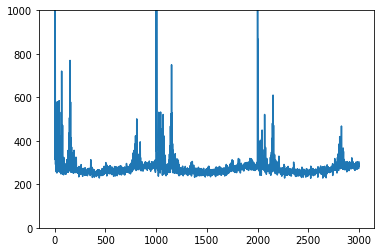

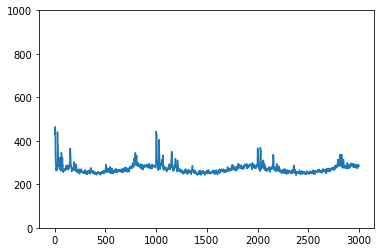

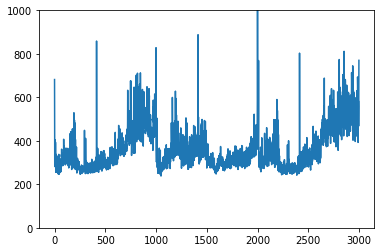

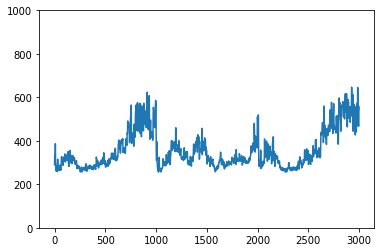

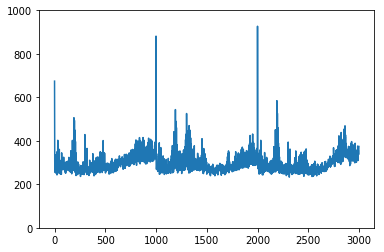

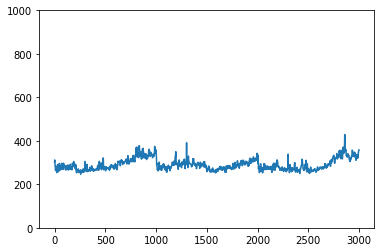

In [26]:
from scipy.signal import medfilt
for i in range(10):
    test_ts = x_train[i, :].copy()
    plt.plot(test_ts)
    plt.ylim(0, 1000)
    plt.show()
    
    test_ts = medfilt(test_ts, kernel_size=5)
    plt.plot(test_ts)
    plt.ylim(0, 1000)
    plt.show()

In [27]:
x_train_cp = x_train.copy()
for i in range(len(x_train)):
    x_train_cp[i, :] = medfilt(x_train[i, :], kernel_size=5)

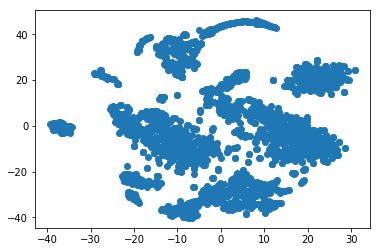

In [28]:
from sklearn.preprocessing import MinMaxScaler
#x_train_cp = np.clip(x_train_cp, a_max=1000, a_min=0)
x_train_cp = MinMaxScaler().fit_transform(x_train_cp)
bhtsne_ = BHTSNE(dimensions=2, perplexity=30.0, theta=0.5, rand_seed=-1, max_iter=10000)
tsne_train = bhtsne_.fit_transform(x_train)
plt.plot(tsne_train[:, 0], tsne_train[:, 1], "o")
plt.show()

In [85]:
from sklearn.cluster import KMeans
train_sig_ids = np.unique(train_meta['id_measurement'].values)
best_n_clusters = 10
clt = KMeans(n_clusters=best_n_clusters, random_state=RANDOM_SEED).fit(tsne_train)
train_clusters = pd.DataFrame(clt.labels_, columns=['cluster'], index=pd.Index([int(x) for x in train_sig_ids], name='id_measurement'))
print(train_clusters.shape)
train_clusters.head()

(2904, 1)


,cluster
id_measurement,
0,7
1,5
2,7
3,1
4,3


In [86]:
train_clusters.reset_index().groupby("cluster").size()

cluster
0    370
1    327
2    275
3    337
4    244
5    380
6    293
7    309
8    244
9    125
dtype: int64

In [87]:
train_clusters.to_csv("./save/check_clustering/train_clusters.csv", header=True, index=True)

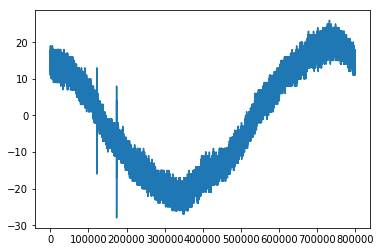

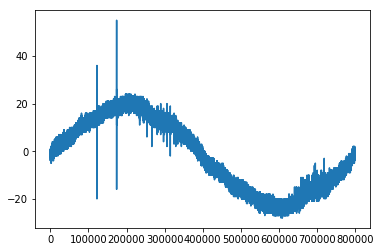

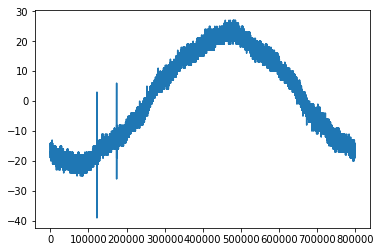

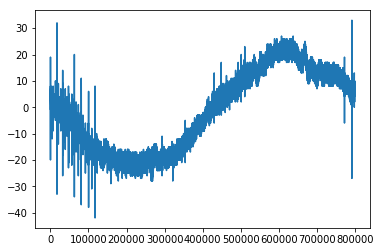

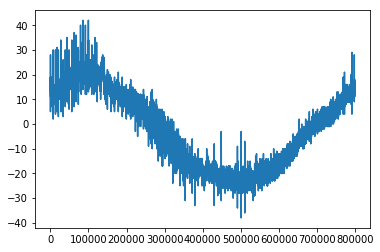

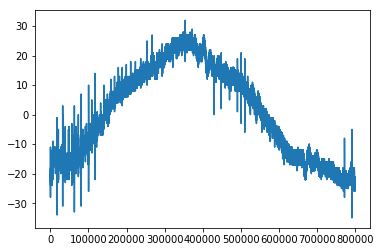

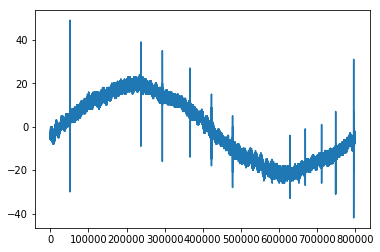

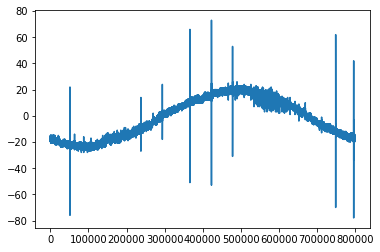

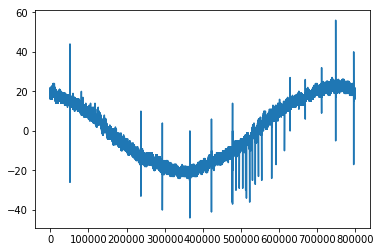

KeyboardInterrupt: 

In [81]:
cluster = 10
id_meas_list = train_clusters[train_clusters == cluster].dropna().index.tolist()
for id_meas in id_meas_list:
    signal_ids = train_meta.query("id_measurement == @id_meas")["signal_id"].values
    praq_data = pq.read_pandas('../data/input/train.parquet', columns=[str(i) for i in signal_ids]).to_pandas()
    for i in range(3):
        plt.plot(praq_data[str(signal_ids[i])])
        plt.show()

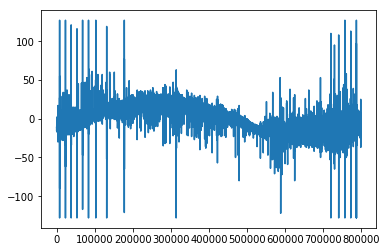

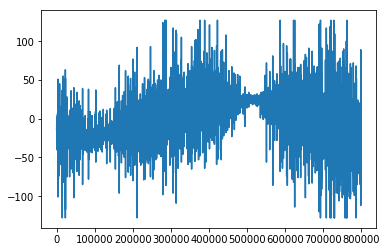

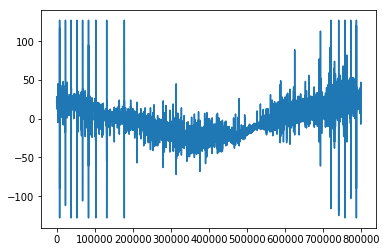

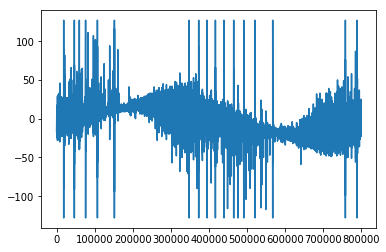

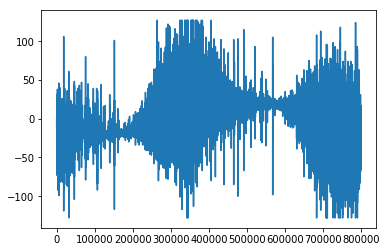

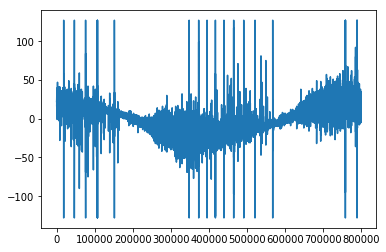

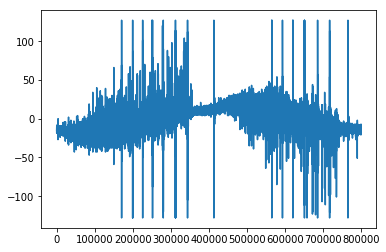

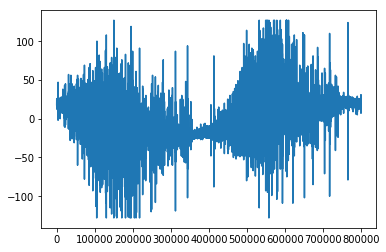

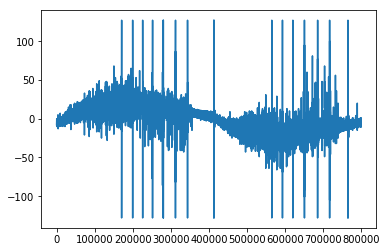

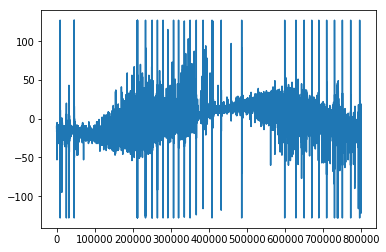

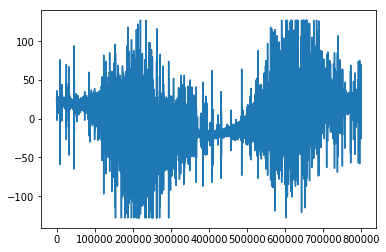

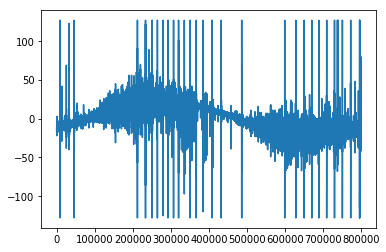

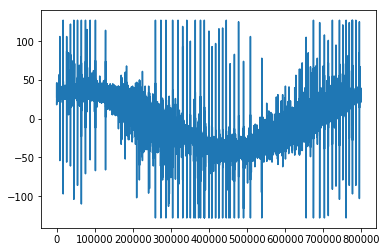

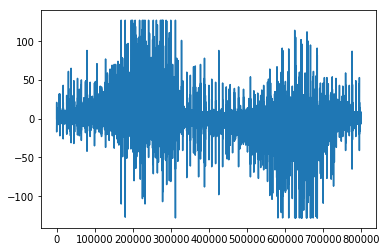

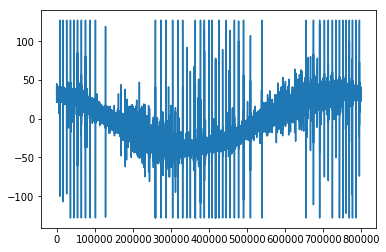

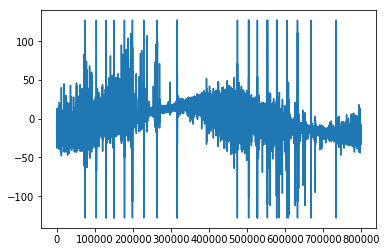

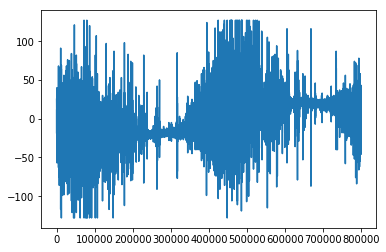

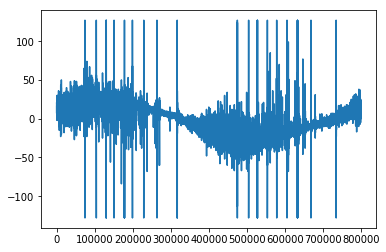

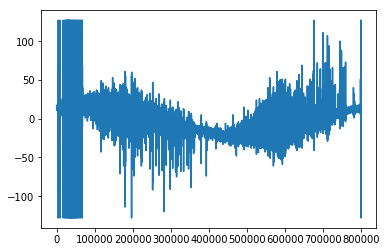

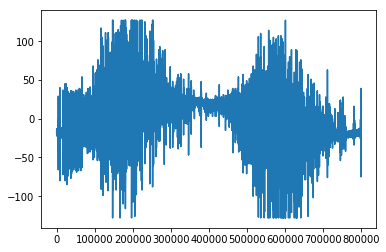

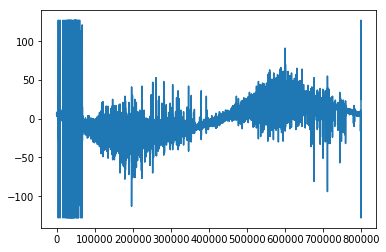

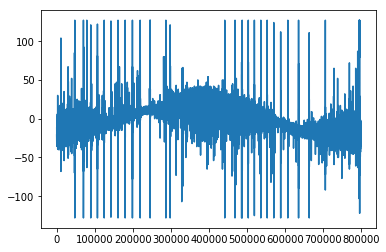

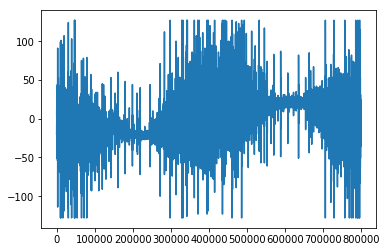

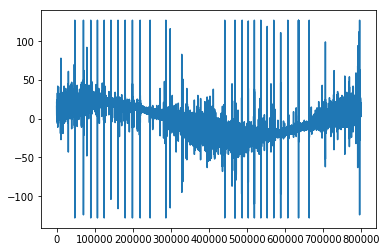

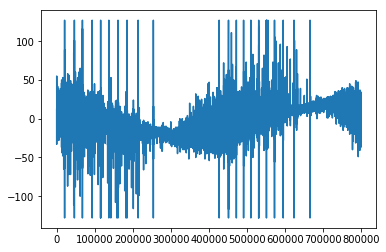

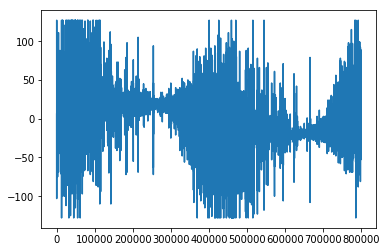

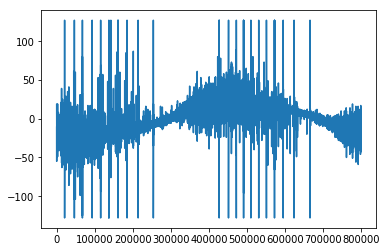

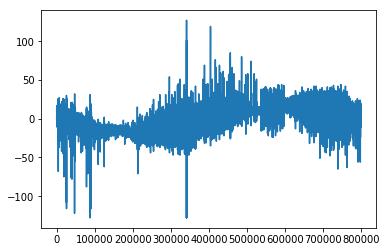

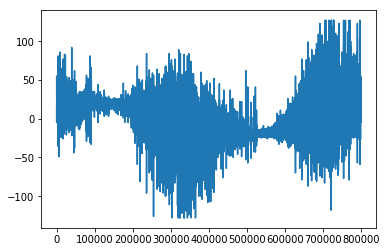

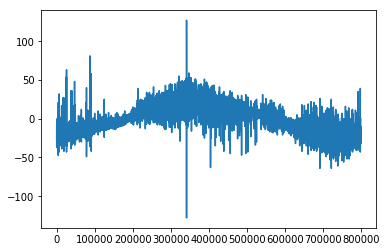

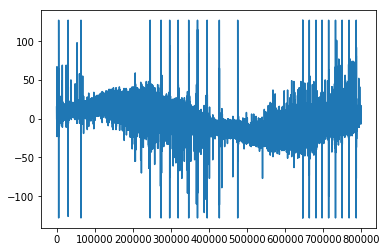

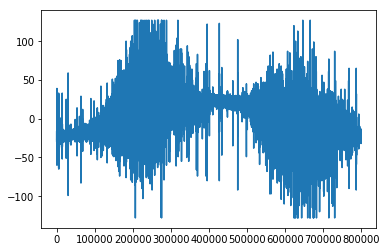

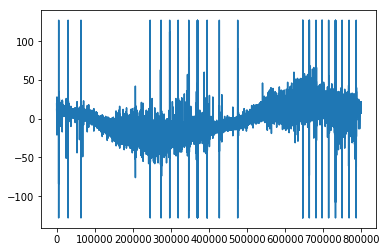

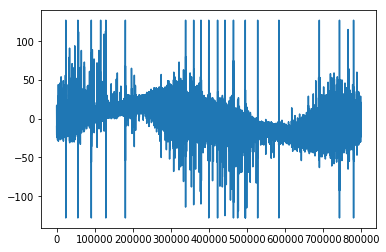

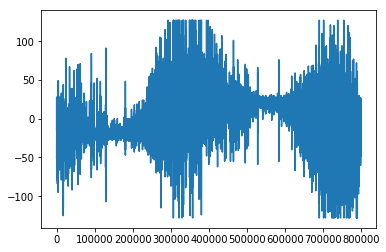

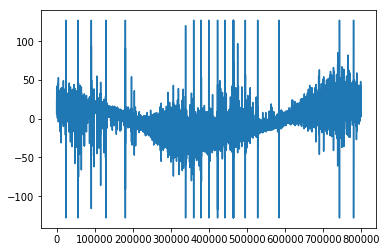

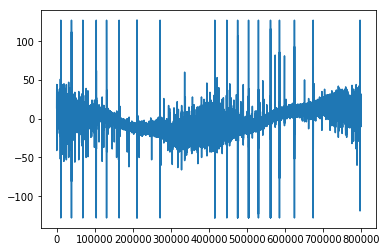

KeyboardInterrupt: 

In [71]:
cluster = 16
id_meas_list = train_clusters[train_clusters == cluster].dropna().index.tolist()
for id_meas in id_meas_list:
    signal_ids = train_meta.query("id_measurement == @id_meas")["signal_id"].values
    praq_data = pq.read_pandas('../data/input/train.parquet', columns=[str(i) for i in signal_ids]).to_pandas()
    for i in range(3):
        plt.plot(praq_data[str(signal_ids[i])])
        plt.show()